# Word2Vec Under the hood


word2vec이 어떤게 구현되는지 알아보자. 

## References

이론

* [BEOMSU KIM /word2vec 관련 이론 정리](https://shuuki4.wordpress.com/2016/01/27/word2vec-%EA%B4%80%EB%A0%A8-%EC%9D%B4%EB%A1%A0-%EC%A0%95%EB%A6%AC/)

코드

* [Minsuk Heo 허민석](https://www.youtube.com/channel/UCxP77kNgVfiiG6CXZ5WMuAQ)
  - [딥러닝 자연어처리 Word2Vec](https://www.youtube.com/watch?v=sY4YyacSsLc)
  - [python_tutorial/data_science/nlp/word2vec_tensorflow.ipynb](https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb)★
  
* tensorflow tutorial
  - [representation/word2vec](https://www.tensorflow.org/tutorials/representation/word2vec)
  - [representation/word2vec 한글판](https://tensorflowkorea.gitbooks.io/tensorflow-kr/g3doc/tutorials/word2vec/)
  - [tensorflow/models/tutorials/embedding](https://github.com/tensorflow/models/tree/master/tutorials/embedding)

* ADVENTURES IN MACHINE LEARNING
  - [Word2Vec word embedding tutorial in Python and TensorFlow](https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/)

## Input Data 준비하기

In [40]:
raw_corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

WINDOW_SIZE = 2

In [41]:
def remove_stop_words( line, stop_words_list ):
    tmp = [ word for word in line.split() if word not in stop_words_list ]
    return " ".join( tmp )


In [42]:
from collections import Counter

def get_dicts( corpus ):
    words = ( " ".join( corpus ) ).split()
    cnt = Counter( words )
    dic = list( cnt.keys() )
    return {
        'cnt': cnt,
        'dic': dic,
        'dic2idx': dict( [ (w, i) for i, w in enumerate( dic ) ] ),
        'frq': list( cnt.values() ),
        'size': len( dic )
    }

In [43]:
def get_skip_gram( corpus, window_size ):
    rst = []
    for line in corpus:
        words = line.split()
        line_size = len( words )
        for i, w in enumerate( words  ):
            left_lim = max( i - window_size, 0 )
            right_lim = min( i + window_size, line_size ) + 1
            neighbors = words[ left_lim:right_lim ]
            for neighbor in neighbors:
                if w != neighbor : rst.append( ( w, neighbor) )
    return rst


In [44]:
stop_words_list = ['is', 'a', 'will', 'be']
corpus = [ remove_stop_words( line, stop_words_list ) for line in raw_corpus ]
dicts = get_dicts( corpus )
skip_grams = get_skip_gram( corpus, WINDOW_SIZE )
print(skip_grams)

[('king', 'strong'), ('king', 'man'), ('strong', 'king'), ('strong', 'man'), ('man', 'king'), ('man', 'strong'), ('queen', 'wise'), ('queen', 'woman'), ('wise', 'queen'), ('wise', 'woman'), ('woman', 'queen'), ('woman', 'wise'), ('boy', 'young'), ('boy', 'man'), ('young', 'boy'), ('young', 'man'), ('man', 'boy'), ('man', 'young'), ('girl', 'young'), ('girl', 'woman'), ('young', 'girl'), ('young', 'woman'), ('woman', 'girl'), ('woman', 'young'), ('prince', 'young'), ('prince', 'king'), ('young', 'prince'), ('young', 'king'), ('king', 'prince'), ('king', 'young'), ('princess', 'young'), ('princess', 'queen'), ('young', 'princess'), ('young', 'queen'), ('queen', 'princess'), ('queen', 'young'), ('man', 'strong'), ('strong', 'man'), ('woman', 'pretty'), ('pretty', 'woman'), ('prince', 'boy'), ('prince', 'king'), ('boy', 'prince'), ('boy', 'king'), ('king', 'prince'), ('king', 'boy'), ('princess', 'girl'), ('princess', 'queen'), ('girl', 'princess'), ('girl', 'queen'), ('queen', 'princess')

## 학습 준비하기

In [45]:
import numpy as np

def to_one_hot( idx, dim ):
    one_hot = np.zeros( dim )
    one_hot[ idx ] = 1
    return one_hot



In [46]:
ONE_HOT_DIM = dicts.get('size')

X, Y = [], []
for x, y in skip_grams:
    X.append( to_one_hot( dicts.get('dic2idx')[ x ], ONE_HOT_DIM ) )
    Y.append( to_one_hot( dicts.get('dic2idx')[ y ], ONE_HOT_DIM ) )


### Define Tensor Graph 

In [47]:
import tensorflow as tf

EMBEDDING_DIM = 2
LEARNING_RATE = 0.05
EPOCHS = 20000

X_train = np.asarray(X)
Y_train = np.asarray(Y)

x = tf.placeholder( tf.float32, shape=( None, ONE_HOT_DIM ) )
y_label = tf.placeholder( tf.float32, shape=( None, ONE_HOT_DIM ) )

# Hidden Layer
W1 = tf.Variable( tf.random_normal( [ ONE_HOT_DIM, EMBEDDING_DIM ] ) )
b1 = tf.Variable( tf.random_normal( [1] ) )
hidden_layer = tf.add( tf.matmul(x, W1), b1 )

# Output Layer
W2 = tf.Variable( tf.random_normal( [ EMBEDDING_DIM, ONE_HOT_DIM ] ) )
b2 = tf.Variable( tf.random_normal( [1] ) )
output_layer = tf.add( tf.matmul( hidden_layer, W2 ), b2 )

# Activation Function
prediction = tf.nn.softmax( output_layer )

# Loss Function : cross entropy
loss = tf.reduce_mean( -tf.reduce_sum( y_label * tf.log(prediction ), axis=[1] ) )

train_op = tf.train.GradientDescentOptimizer( LEARNING_RATE ).minimize( loss )

### Train

In [48]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run( init )
feed_dict = { x: X_train, y_label: Y_train }

for i in range( EPOCHS ):
    sess.run( train_op, feed_dict = feed_dict )
    if i % 2000 == 0 :
        print( "Epochs " + str(i) + " / Loss is : ", sess.run( loss, feed_dict=feed_dict ) )



ITERATION 0 / Loss is :  3.4971507
ITERATION 2000 / Loss is :  1.9030579
ITERATION 4000 / Loss is :  1.8318492
ITERATION 6000 / Loss is :  1.8036281
ITERATION 8000 / Loss is :  1.7875571
ITERATION 10000 / Loss is :  1.775905
ITERATION 12000 / Loss is :  1.7657808
ITERATION 14000 / Loss is :  1.7565522
ITERATION 16000 / Loss is :  1.7485894
ITERATION 18000 / Loss is :  1.74234


## Word2Vec 도출

In [49]:
vectors = sess.run( W1 + b1 )
print( vectors )

[[ 4.7780275e-03  1.0523497e+00]
 [-5.0781786e-01  6.9142127e+00]
 [ 1.3854557e-01  7.5698662e-01]
 [-1.0941539e+00 -3.0186993e-01]
 [-5.4804554e+00 -1.4451005e+00]
 [-4.7581014e-01 -5.9342837e-01]
 [-5.5942690e-01  2.1995111e+00]
 [-2.3880747e-01  1.5002263e-01]
 [-3.3036895e+00 -4.9603635e-01]
 [-1.7420025e+00  3.5040774e+00]
 [-2.7706466e+00 -1.0772343e+00]
 [-3.7491488e+00 -2.4490780e-01]]


### DataFrame으로 표현

In [50]:
import pandas as pd
w2v_df = pd.DataFrame( vectors, columns=['x1', 'x2'] )
w2v_df['word'] = dicts.get("dic")
w2v_df = w2v_df[ [ 'word', 'x1', 'x2' ] ] 
w2v_df

,word,x1,x2
0,king,0.004778,1.052350
1,strong,-0.507818,6.914213
2,man,0.138546,0.756987
3,queen,-1.094154,-0.301870
4,wise,-5.480455,-1.445101
5,woman,-0.475810,-0.593428
6,boy,-0.559427,2.199511
7,young,-0.238807,0.150023
8,girl,-3.303689,-0.496036
9,prince,-1.742002,3.504077


### Plot으로 표현

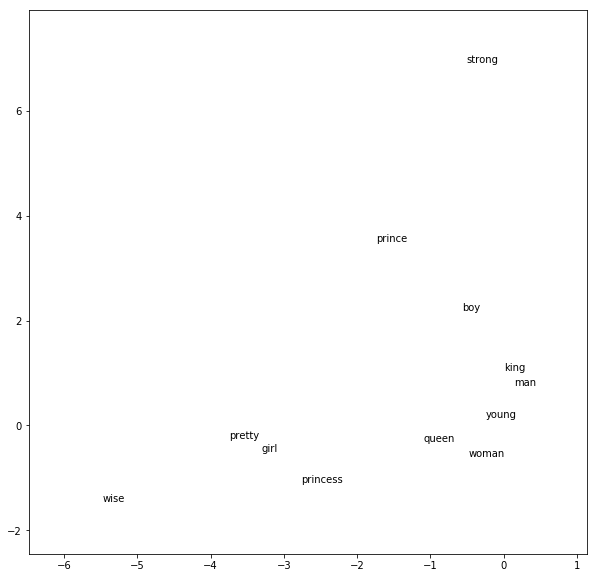

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip( w2v_df['word'], w2v_df['x1'], w2v_df['x2'] ):
    ax.annotate( word, ( x1, x2 ) )

PADDING = 1.0
x_axis_min = np.amin( vectors, axis=0)[0] - PADDING
x_axis_max = np.amax( vectors, axis=0)[0] + PADDING
y_axis_min = np.amin( vectors, axis=0)[1] - PADDING
y_axis_max = np.amax( vectors, axis=0)[1] + PADDING

plt.xlim( x_axis_min, x_axis_max )
plt.ylim( y_axis_min, y_axis_max )
plt.rcParams['figure.figsize'] = (10, 10)

plt.show()